In [15]:
from ParametricGraphModels.ADC_SBM import ADC_SBM, from_config
from config import Scenarios
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import sem  
import seaborn as sns
from graspy.simulations import sbm
import networkx as nx
import copy
 
import pandas as pd
from sklearn.datasets import make_spd_matrix
from statsmodels.multivariate.manova import MANOVA
import concurrent.futures
from functools import wraps
import multiprocessing
import concurrent.futures

In [14]:
def change_size(scenario, p):
    s = copy.deepcopy(scenario)
    s["community_sizes"] = [round(i * p) for i in scenario["community_sizes"]]
    s["cluster_sizes"] = [round(i * p) for i in scenario["cluster_sizes"]]
    return s


print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  4


In [21]:
illustrative_1 = {

        "name": "perfect",
        "task": "multiclass",

        "community_sizes": [200, 200, 200, 200, 200],
        "cluster_sizes": [200, 200, 200, 200, 200], # same as com_size -> overlap
        "m_features": 6,
        # "k_clusters": 4,
        "alpha": 2, "beta": 20, "lmbd": .5,

        "between_com_prob_range": (.1, .1),
        "within_com_prob_range": (.5, .5),  # within_range > between -> assortative

        "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
        "within_clust_variance_range": (1, 1),

        "within_clust_covariance_range": (0, 0),  # not important; fixed
        "centroid_covariance_range": (0, 0),  # not important; fixed

        "n_targets": 5,
        "degree_importance": 0,  # irrelevant

        "x_importance": 4,
        "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

        "community_importance": 4,  # this scale shouldn't be interpreted analog to x and degree
        "community_importance_exponent": 1,
        "model_error": 2,
        "splitweights": [.7, .2, .1]

    }  # perfect 

illustrative_2 = {
    # Well seperated by community-connectivity + homophily. But irrelevant features, with poor cluster separation.

    "name": "community_relevant",
    "task": "multiclass",

    "community_sizes": [200, 200, 200, 200, 200],
    "cluster_sizes": [100, 100, 300, 200, 300],
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.1, .1),
    "within_com_prob_range": (.5, .5),  # within_range > between -> assortative

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (5, 5),

    "within_clust_covariance_range": (0, 0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 3,
    "degree_importance": 0,  # no meaningfully interpretation

    "x_importance": 1,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 4,  # diag entries
    "community_importance_exponent": 1,
    "model_error": 2,
    "splitweights": [.7, .2, .1]

}  # community relevant   

illustrative_3 = {

    # Relevant community (in terms of parameter) but heterophilic graph.
    # Features are mildly relevant.

    "name": "community_relevant_heterophilic",
    "task": "multiclass",

    "community_sizes": [200, 200, 200, 200, 200],
    "cluster_sizes": [100, 100, 300, 200, 300], # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.4, .4),
    "within_com_prob_range": (.5, .5),

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (1, 1),

    "within_clust_covariance_range": (0, 0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 5,
    "degree_importance": 0,  # no meaningfully interpretation

    "x_importance": 1,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 4,  # diag entries
    "community_importance_exponent": 1,
    "model_error": 2,
    "splitweights": [.7, .2, .1]

}  # community_relevant_heterophilic

illustrative_4 = {
    # Well seperated by features-cluster with relevant parameters.
    # However, no edge clustering and no relevance of community belonging.

    "name": "cluster_relevant",
    "task": "multiclass",

    "community_sizes":  [100, 100, 300, 200, 300],
    "cluster_sizes": [200, 200, 200, 200, 200],  # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.4, .4),
    "within_com_prob_range": (.5, .5),

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (1, 1),

    "within_clust_covariance_range": (0, .0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 5,
    "degree_importance": 1,

    "x_importance": 4,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 1,  # this scale shouldn't be interpreted analog to x and degree
    "community_importance_exponent": 1,
    "model_error": 2,
    "splitweights": [.7, .2, .1]

}  # cluster_relevant

illustrative_5 = {
    # Feature cluster explains target well, but clusters are not well seperated.
    # Communities are well seperated, but not really relevant.

    "name": "non_seperated_cluster_relevant",
    "task": "multiclass",

    "community_sizes":  [100, 100, 300, 200, 300],
    "cluster_sizes": [200, 200, 200, 200, 200], # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4, determined by "cluster_size"
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.4, .4),
    "within_com_prob_range": (.5, .5),  # heterophilic

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (5, 5),

    "within_clust_covariance_range": (0, .0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 5,
    "degree_importance": 0,

    "x_importance": 4,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 1,  # this scale shouldn't be interpreted analog to x and degree
    "community_importance_exponent": 1,
    "model_error": 2,
    "splitweights": [.7, .2, .1]

}  # non_seperated_cluster_relevant

illustrative_6 = {

    "name": "noise",
    "task": "multiclass",

    "community_sizes": [200, 200, 200, 200, 200],
    "cluster_sizes": [200, 200, 200, 200, 200], # same as com_size -> overlap
    "m_features": 6,
    # "k_clusters": 4,
    "alpha": 2, "beta": 20, "lmbd": .5,

    "between_com_prob_range": (.4, .4),
    "within_com_prob_range": (.5, .5),  # within_range > between -> assortative

    "centroid_variance_range": (6, 6),  # spectral detectability of feature cluster
    "within_clust_variance_range": (5, 5),

    "within_clust_covariance_range": (0, .0),  # not important; fixed
    "centroid_covariance_range": (0, 0),  # not important; fixed

    "n_targets": 5,
    "degree_importance": 1,

    "x_importance": 1,
    "feature_info": "cluster",  # "number" or "cluster" use x right away or dummies for cluster

    "community_importance": 2,  # this scale shouldn't be interpreted analog to x and degree
    "community_importance_exponent": 2,
    "model_error": 6,
    "splitweights": [.7, .2, .1]

}  # noise

# Spectral Detactability 

In [ ]:
def get_edge_homophily(scenario_config: dict, n_iter: int) -> float: 

    res = np.zeros(n_iter).reshape(-1)
    for i in tqdm(range(0, n_iter)):
        g = from_config(scenario_config, i)
        res[i] = g.edge_homophily()

    #sns.histplot(res, kde=True, color='blue', bins=10, edgecolor='black')
    #plt.show()
    
    return res

res_h_1 = get_edge_homophily(illustrative_1, 30) #  0.433
res_h_2 = get_edge_homophily(illustrative_2, 30) #  0.205
res_h_3 = get_edge_homophily(illustrative_4, 30) #  0.026
res_h_4 = get_edge_homophily(illustrative_6, 30) #  0.003

np.round(np.var(res_h_1), 3)
np.round(np.var(res_h_2), 3)
np.round(np.var(res_h_3), 3)
np.round(np.var(res_h_4), 3)

In [ ]:
def plot_manova(scenario_config, n_iter):

    res = np.zeros(n_iter).reshape(-1)
    n_insig = np.zeros(n_iter).reshape(-1)
    
    for i in tqdm(range(0,n_iter)):
        g = from_config(scenario_config, i)
        l, p = g.manova_x()
        res[i], n_insig[i] = l, 1 if p > 0.05 else 0  

    #sns.histplot(res, kde=True, color='blue', bins=10, edgecolor='black')
    #plt.show()
    
    return res, n_insig
 
res_m_1, p1 = plot_manova(illustrative_1, 30)  # 0.296
res_m_2, p2 = plot_manova(illustrative_2, 30)  # 0.848
res_m_3, p3 = plot_manova(illustrative_3, 30)  # 0.506
res_m_4, p4 = plot_manova(illustrative_4, 30)  # 


np.round(np.var(res_m_1), 3)
np.round(np.var(res_m_2), 3)
np.round(np.var(res_m_3), 3)
np.round(np.var(res_m_4), 3)

In [26]:
res_m_3

(0.506,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

# New Graph Plot Engine

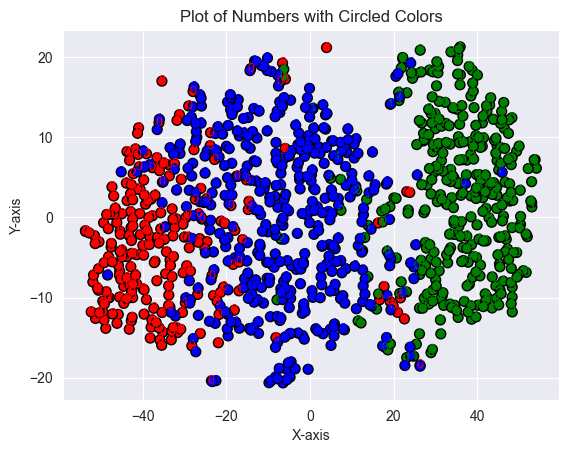

In [22]:
def plot_graph(X, t, c):
    #X = np.array([[1, 2], [3, 4], [5, 6]])  # nx2 matrix of coordinates
    #t = np.array([10, 20, 30])              # Vector of numbers to be plotted
    #c = np.array([1, 2, 3])                 # Vector of colors (as integers)
    
    # Mapping integers to colors
    color_map = {0: 'red', 1: 'green', 2: 'blue'}
    colors = [color_map[color] for color in c]
    
    plt.scatter(X[:, 0], X[:, 1], s=50, facecolors=colors, edgecolors="black")

    [plt.text(x, y, str(text), fontsize=9, ha='center', va='center') for x, y, text in zip(X[:, 0], X[:, 1], t)]


    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot of Numbers with Circled Colors')
    
    # Display plot
    plt.grid(True)
    plt.show()
    
